### Analysing subreddit data using NLP

We will be analysing a reddit community, known as a `subreddit`. For this project, we have chosen [r/geopolitics](https://www.reddit.com/r/geopolitics/) and will perform different analysis techniques on the data scraped from it. The following libraries are majorly used in this project:
- `nltk`: Utilities for natural language processing
- `praw`: Scraping subreddit and user data
- `pandas`: Creating and modifying dataframes

In [1]:
import praw
from dotenv import dotenv_values

config = dotenv_values(".env")

reddit = praw.Reddit(
    client_id=config["CLIENT_ID"],
    client_secret=config["CLIENT_SECRET"],
    user_agent=config["USER_AGENT"],
)

In [2]:
import re

from nrclex import NRCLex

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def analyze_emotion(text: str) -> str:
    lexicon = NRCLex(clean_text(text))
    emotions = lexicon.affect_frequencies
    dominant_emotion = max(emotions, key=emotions.get)
    return dominant_emotion

In [26]:
from datetime import datetime

subreddit = reddit.subreddit("worldnews")
submissions = []

for post in subreddit.top(time_filter="month", limit=None):
    submissions.append([
        post.title,
        post.num_comments,
        datetime.utcfromtimestamp(post.created_utc).strftime("%Y-%m-%d"),
        post.author,
        post.score,
        post.upvote_ratio,
        post.num_crossposts,
        analyze_emotion(post.title),
    ])

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

for post in submissions:
    score = analyzer.polarity_scores(clean_text(post[0]))
    post.append(score["compound"])

In [28]:
import pandas as pd

df = pd.DataFrame(
    submissions,
    columns=["title", "comments", "created", "author", "upvotes", "upvote_ratio", "crossposts", "emotion", "compound"],
)

df["sentiment"] = 0
df.loc[df["compound"] > 0.20, "sentiment"] = 1
df.loc[df["compound"] < -0.20, "sentiment"] = -1

In [29]:
df.drop("compound", axis=1, inplace=True)
df

,title,comments,created,author,upvotes,upvote_ratio,crossposts,emotion,sentiment
0,Israel resumes water supply to southern Gaza a...,5261,2023-10-15,HappyBavarian,33095,0.91,4,positive,-1
1,Israel says no humanitarian break to Gaza sieg...,13588,2023-10-12,project_95,30001,0.89,7,surprise,0
2,Hamas official promises: 'We'll repeat Oct. 7 ...,7375,2023-11-01,BinaryPhinary2,28444,0.78,13,fear,1
3,Zelensky confirms destruction of major Russian...,871,2023-11-06,Ask4MD,25379,0.94,0,anger,-1
4,Terrorist Attack In The Center Of Brussels: Tw...,5976,2023-10-16,Gully97,23925,0.92,6,fear,-1
...,...,...,...,...,...,...,...,...,...
995,Macron says 'Islamist terrorism' rising in Eur...,140,2023-10-17,BastianMobile,430,0.86,0,fear,-1
996,Hezbollah says Israel to 'pay price' after str...,196,2023-11-05,Mikelitoris88,423,0.77,0,anger,-1
997,UAE sends medical aid to Egypt intended for Ga...,47,2023-10-14,NilsuBerk,420,0.93,0,positive,0
998,At least 21 journalists killed since Hamas-Isr...,185,2023-10-19,saddom_,419,0.81,0,fear,-1


<Axes: title={'center': 'Distribution of emotions on r/Geopolitics'}, xlabel='Emotion', ylabel='Posts Count'>

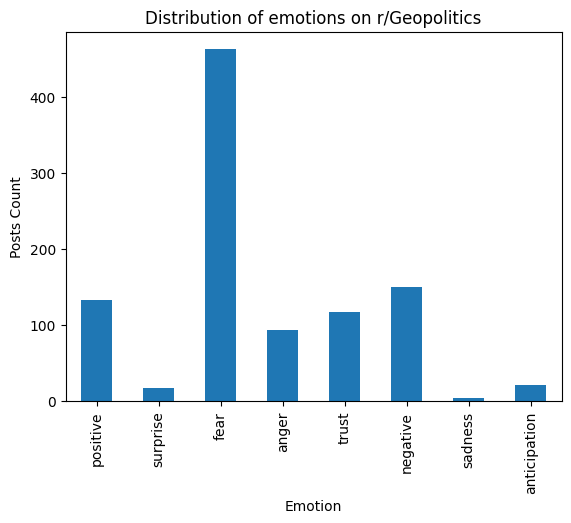

In [30]:
emotion_count = df.emotion.value_counts(sort=False)
emotion_count.plot.bar(xlabel="Emotion", ylabel="Posts Count", title="Distribution of emotions on r/Geopolitics")

<Axes: title={'center': 'Distribution of sentiments on r/Geopolitics'}, xlabel='Sentiment', ylabel='Posts Count'>

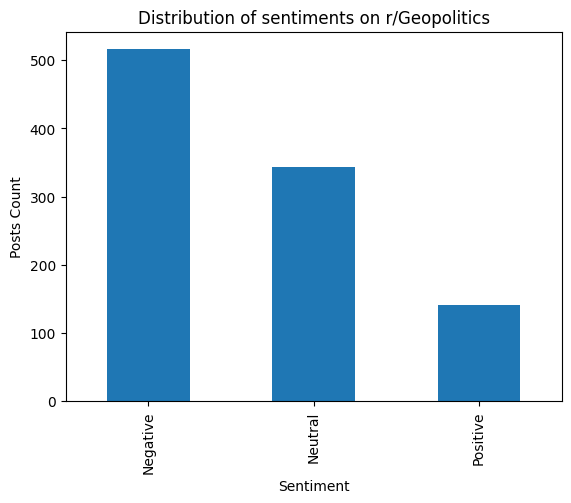

In [31]:
sentiment_count = df.sentiment.value_counts()
sentiment_count.index = ["Negative", "Neutral", "Positive"]
sentiment_count.plot.bar(xlabel="Sentiment", ylabel="Posts Count", title="Distribution of sentiments on r/Geopolitics")

<Axes: title={'center': 'Posting frequency on r/Geopolitics'}, xlabel='Date Created', ylabel='Posts Count'>

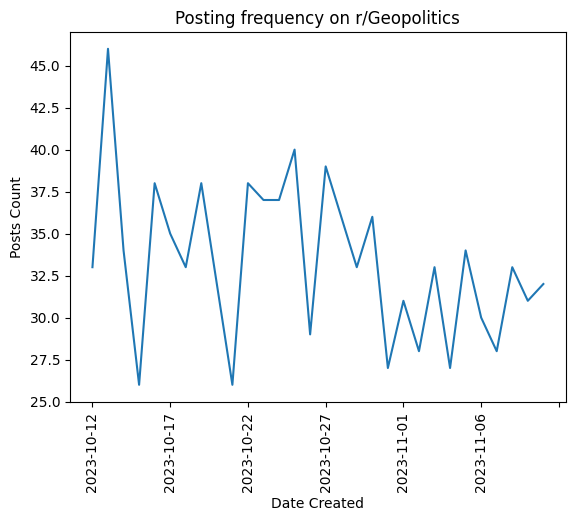

In [32]:
created_count = df.created.value_counts().sort_index()
created_count.plot.line(xlabel="Date Created", ylabel="Posts Count", title="Posting frequency on r/Geopolitics", rot=90)

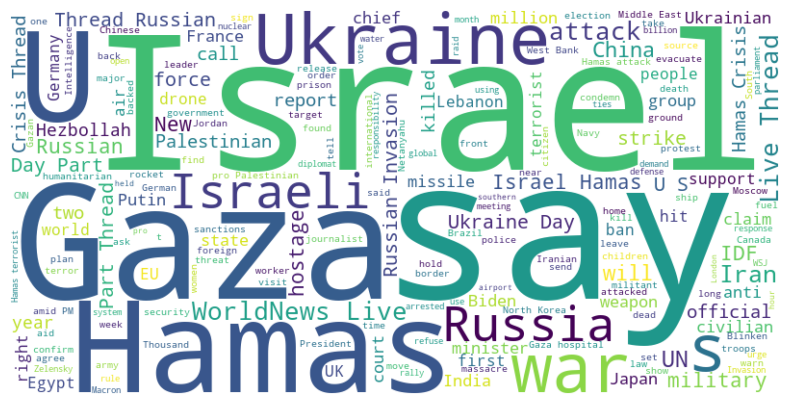

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

words = []

for title in df.title:
    words.extend(title.split())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()